# Library
berikut ini adalah library yang digunakan untuk mendeklarasikan segala macam library dari python untuk ekstrasi fitur yang diperlukan 

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.segmentation as seg
import pydicom
import os

# Function
fungsi2 ini untuk memunculkan fungsi showImage serta masking pada tahapan selanjutnya

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

def masking(image):
    foreground_value = 255
    mask = np.uint8(image == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    image = np.zeros_like(image)
    image[labels == largest_label] = foreground_value
    ShowImage('masking',image,'rgb')

kita mengambil salah satu file untuk sample

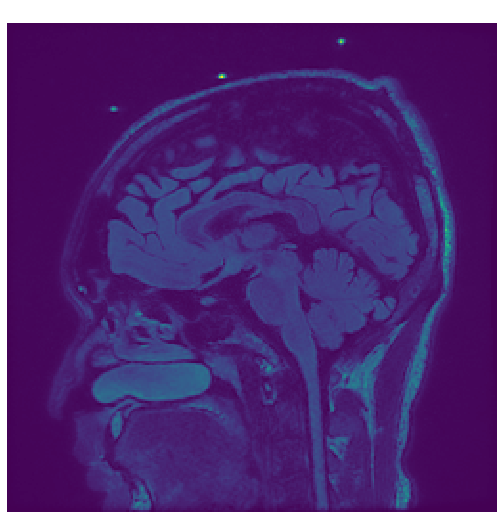

In [3]:
basepath ="C://Users//Asus//Desktop//tugas//RPLB (python)//Simple_Brain_MRI_Segmentation//dicom//"
d = pydicom.read_file(basepath + "Z108")
file = np.array(d.pixel_array)
img = file
ShowImage('origin',img,'rgb')

In [4]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Otsu Thresholding
ini adalah satu dari banyak threshold, yang bisa digunakan, karena berdasarkan binary maka threshold ini banyak sekali diaplikasikan disetiap data.

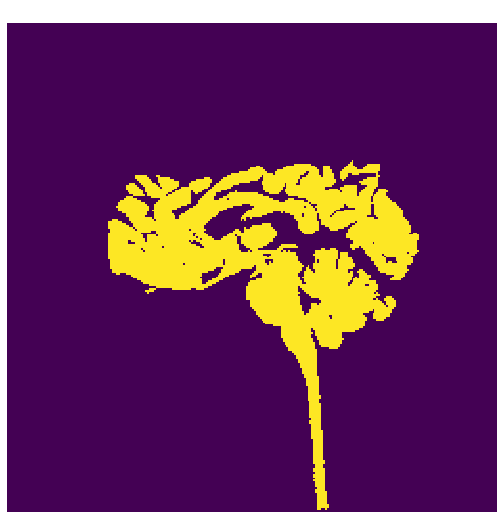

In [5]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
binarized = np.zeros_like(binarized)
binarized[labels == largest_label] = foreground_value
ShowImage('binarized',binarized,'rgb')

# invers otsu
fungsi ini untuk membalikan nilai dari otsu, yang awal mula nilai dari 0 menjadi 1 dan sebaliknya.

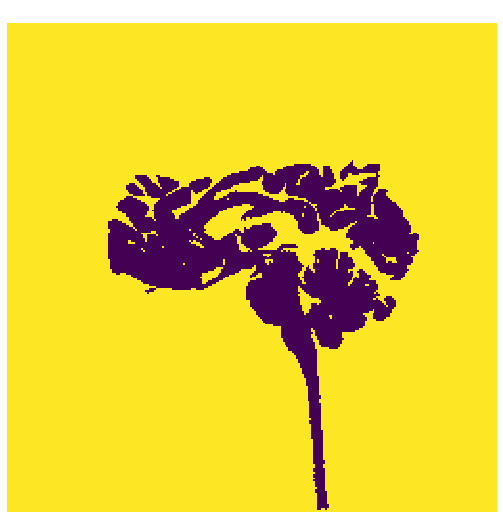

In [6]:
invers = cv2.bitwise_not(binarized)
ShowImage('invers',invers,'rgb')

# Erosion from otsu
lalu proees erosi ini digunakan kami untuk menghasilkan salah morphology yaitu erosi, fungsinya untuk mengikis bagian tertentu dari gambar sesuai iterasi yang diberikan, bila diberikan banyak iterasi lebih banyak lagi yang terkikis.

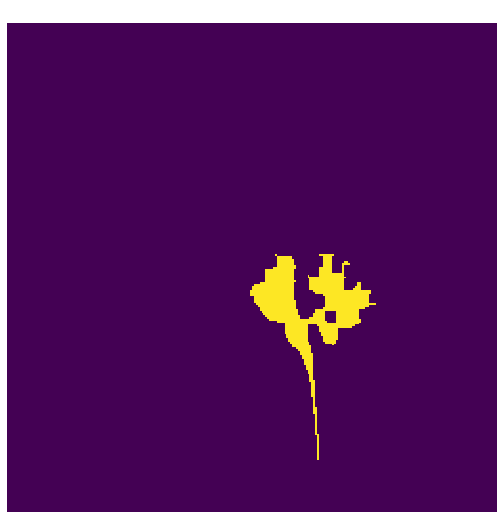

In [7]:
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(binarized,kernel,iterations = 1)
masking(erosion)

# Opening from erosion
morphology ini berfungsi untuk membuka bagian tertentu dari gambar untuk bisa disegmentasi ke tahap selanjutnya.

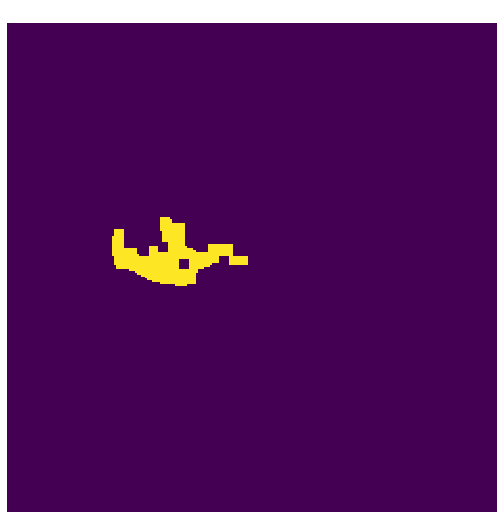

In [11]:
bentuk = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, bentuk)
masking(opening)

# Closing from erosion
kebalikan dari opening, fungsinya untuk menutup bagian dari titik gambar tertentu untuk didapatkan gambar yang diinginkan.

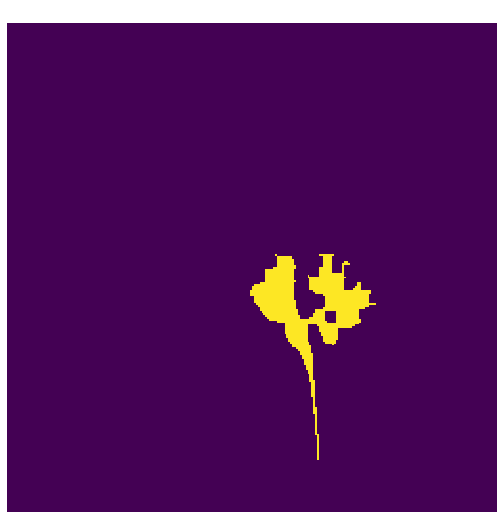

In [8]:
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
masking(closing)

# closing from invers
hasil dari closing pada invers sebelumnya. jelas digunakan morphologi ini dikarenakan morphology opening akan membuka titik tertentu dari gambar. sehingga kita hanya menggunakan fungsi ini untuk tahapan ini.

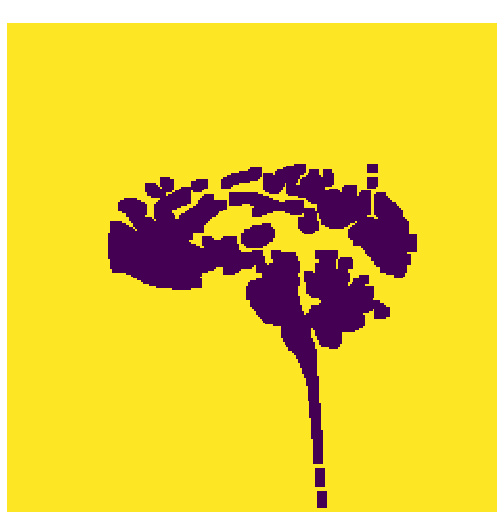

In [12]:
kernel = np.ones((5, 5), np.uint8)
closing_invers = cv2.morphologyEx(invers, cv2.MORPH_CLOSE, kernel)
masking(closing_invers)

# Dilation from opening 
dilasi berfungsi untuk menggemukkan atau menebalkan dari titik tertentu dari gambar untuk didapatkan nilai yang kita inginkan, sesuai dengan tahapan sebelumnya. untuk mendapatkan gambar yang lebih bagus lagi.

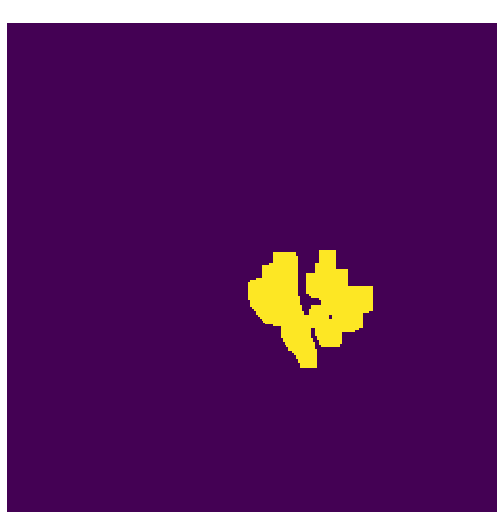

In [13]:
shape = np.ones((5, 5), np.uint8)
dilation_open = cv2.dilate(opening,shape,iterations = 1)

foreground_value = 255
mask = np.uint8(dilation_open == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
dilation_open = np.zeros_like(dilation_open)
dilation_open[labels == largest_label] = foreground_value
ShowImage('dilasi_akhir',dilation_open,'rgb')

# Dilation from closing
sama halnya sebelumnya, fungsi ini, digunakan untuk proses selanjutnya untuk tahapan sebelumnya yaitu closing

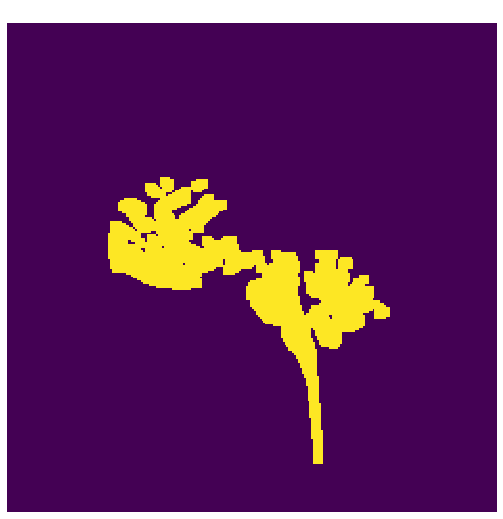

In [9]:
bentukan = np.ones((5, 5), np.uint8)
dilasi_close = cv2.dilate(closing,bentukan,iterations = 1)

foreground_value = 255
mask = np.uint8(dilasi_close == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
dilasi_close = np.zeros_like(dilasi_close)
dilasi_close[labels == largest_label] = foreground_value
ShowImage('dilasi_akhir',dilasi_close,'rgb')

# dilation from closing_invers

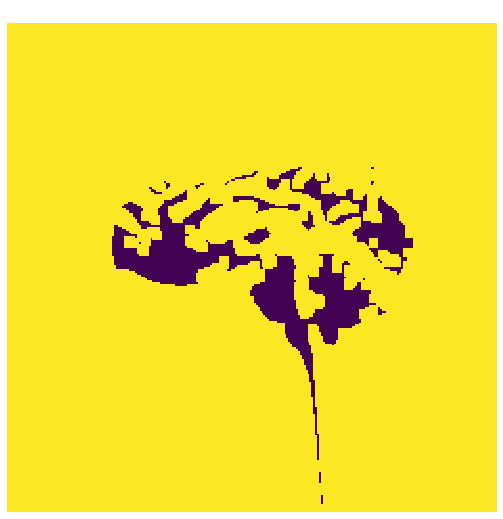

In [14]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(closing_invers,bentukan,iterations = 1)
masking(dilasi)

# Skull Stripping
fungsi ini untuk menghasilkan gabungan dari segmentasi awal hingga akhir, namun bagian tertentu saja yang kita inginkan. Misalkan hal ini dimulai dari hasil pertama kali (hasil) sampai dilasi open. lalu dilanjutkan kmeans untuk mendapatkan color quantization dalam gambar tersebut.

In [15]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = dilation_open)
brain_pixels = skull_stripped_image[dilation_open == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[48 40 55 ... 58 59 45] Brain Pixels
[[48.]
 [40.]
 [55.]
 ...
 [58.]
 [59.]
 [45.]] Kmeans Input
(3, 50, 0.01) criteria Paramaters
(2243, 1) K-means segmentation


# Segmented Image
proses ini diebut sebagai segmentasi, keluaran dari skull stripping sebelumnya kita keluarkan. sesuai dengan gambar yang diinginkan.

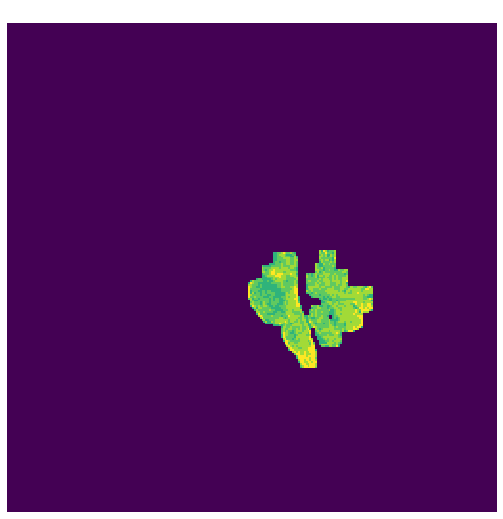

In [16]:
segmented_image = np.zeros_like(dilation_open)
segmented_image[dilation_open == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

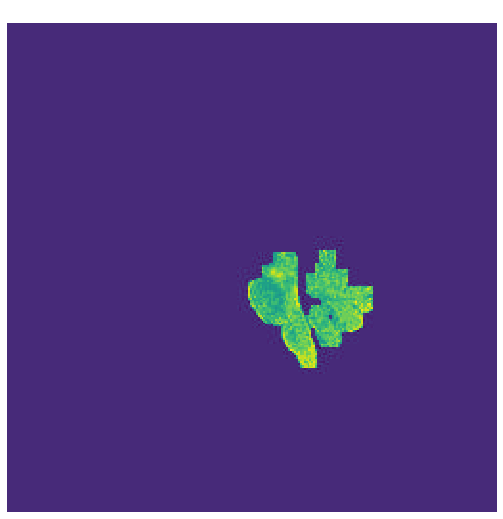

In [17]:
path = "C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\experiment\\"
plt.imsave(path + "hasil_perc2.jpeg", segmented_image)
image = cv2.imread(path + "hasil_perc2.jpeg", 0)
ShowImage('ambil',image,'rgb')

# Active Contour
ini adalah fitur yang berfungsi untuk mencari nilai tertentu dari gambar mana yang ingin kita dapatkan gambarnya. salah satunya yaitu segmentasi otak ini. karena bersifat fitur. maka hanya sebatas ekstra dari hasil sebelumnya.

In [21]:
def circle_points(resolution, center, radius):
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [140, 150], 50)[:-1]

def image_show(image, nrows=1, ncols=1, cmap='gray'): 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9)) 
    ax.imshow(image, cmap='gray') 
    ax.axis('off') 
    return fig, ax

In [22]:
fig, ax = image_show(segmented_image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

In [24]:
import skimage.color as color 
image_gray = color.rgb2gray(segmented_image) 
image_show(image_gray);

In [25]:
snake = seg.active_contour(image_gray, points,alpha=0.06,beta=0.3)
fig, ax = image_show(segmented_image)
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

In [0]:
# # Display
# captions = ["1. Original image", "2. Thresholding",
#             "3. Largest connected component + Mathematical morphology",
#             "4. Segmented image"]
# horizontal_layout = np.hstack(
#     (hasil, binarized, dilasi_close, segmented_image))
# cv2.imshow(" | ".join(captions), horizontal_layout)

# cv2.waitKey(0)

# Row All-in One
Munculkan semua gambar dalam 1 folder

In [5]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
IMAGE_PATHS = os.listdir("C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\")

list_b = []
for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    list_b.append(hasil)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_b[i])
plt.show()

In [82]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")

list_b = []
for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    foreground_value = 255
    mask = np.uint8(binarized == foreground_value)
    
    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    binarized = np.zeros_like(binarized)
    binarized[labels == largest_label] = foreground_value
    
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(binarized,kernel,iterations = 1)
    
    foreground_value = 255
    mask = np.uint8(erosion == foreground_value)
    
    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    erosion = np.zeros_like(erosion)
    erosion[labels == largest_label] = foreground_value
    
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
    
    foreground_value = 255
    mask = np.uint8(closing == foreground_value)
    
    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    closing = np.zeros_like(closing)
    closing[labels == largest_label] = foreground_value
    
    shape = np.ones((5, 5), np.uint8)
    dilation_open = cv2.dilate(opening,shape,iterations = 1)

    foreground_value = 255
    mask = np.uint8(dilation_open == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    dilation_open = np.zeros_like(dilation_open)
    dilation_open[labels == largest_label] = foreground_value

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilation_open)
    brain_pixels = skull_stripped_image[dilation_open == foreground_value]
    
    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
    
    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS
    
    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)
    
    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
    
    segmented_image = np.zeros_like(dilation_open)
    segmented_image[dilation_open == foreground_value] = labels
    
    list_b.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_b[i])
plt.show()

In [26]:
import numpy as np

def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [32]:
dice(dilation_open,segmented_image)

In [35]:
def dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")        
    im_sum = im1.sum() + im2.sum()

    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / im_sum

In [38]:
dice(hasil, segmented_image, empty_score=1.0)

# Sihooullette coefficeent
# Dunn Index